# Formula learning

A toy example to learn a formula to predict a synthetic data


Let's say we have a regression problem to predict a target value in $\cal{R}$. 
Input data has $M$ features and a target is computed as 
$$
y_{i} = f(\mathbf x)
$$
we will try various functions $f$ to observe ability to learn it using a DNN.

## A warm-up

Let us predict a simple function : $f(\mathbf x) = 1 + \sum_{i} x_i$

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [26]:
import os

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


n_samples = 10000
n_features = 10
x_max = 100.0
x_min = -100.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min
test_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [27]:
def f(x):
    return np.sum(x) + 1.0

In [28]:
trainval_y = np.zeros((n_samples, 1))
test_y = np.zeros((n_samples, 1))

for i, x in enumerate(trainval_x):
    trainval_y[i, 0] = f(x)
    
for i, x in enumerate(test_x):
    test_y[i, 0] = f(x)    

In [8]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [9]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,15.790368,-8.901867,17.448230,-57.029565,-6.442697,-64.240952,-9.762370,-78.481390,-89.620167,81.789198,-198.451214
1,89.150978,27.308455,-37.046431,-34.713958,-51.965157,-11.949938,-15.304973,67.151997,-2.752915,71.278274,102.156333
2,13.926858,72.509506,49.823661,-47.285124,-91.160410,-24.765865,75.429079,-62.649061,-23.597660,-85.976662,-122.745680
3,26.286640,-82.537791,-73.182807,-87.534468,77.203457,-63.857090,-27.310473,-2.277888,-79.223077,-38.189372,-349.622868
4,-29.871511,24.656432,93.281033,-93.728025,-1.502599,-99.474990,80.294358,-48.623329,-46.741250,-55.630339,-176.340219


In [10]:
df.loc[0, ['x_%i' % i for i in range(10)]].sum() + 1.0, df.loc[1, ['x_%i' % i for i in range(10)]].sum() + 1.0 

(-198.45121400520011, 102.15633332358843)

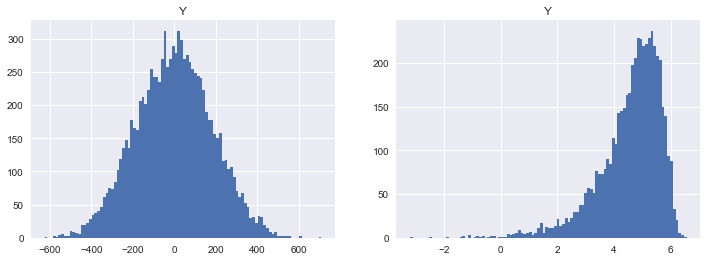

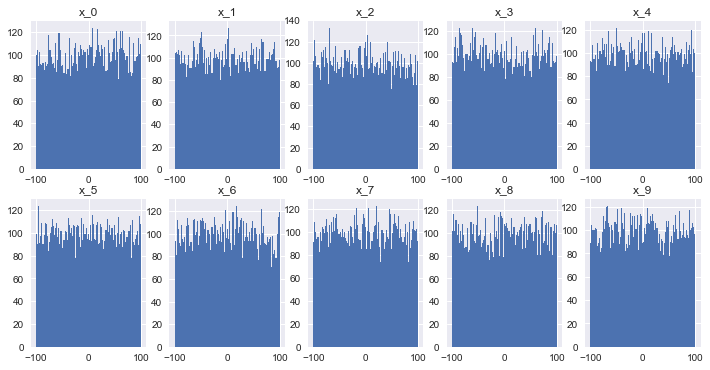

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.subplot(2, n_features/2, i+1)
    df['x_%i' % i].hist(bins=100)
    plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = b_i + \langle W_i, \mathbf x \rangle,
$$

In [12]:
import tensorflow as tf
tf.reset_default_graph()
from tf_bike.train import Trainer

In [32]:
def nn(x):    
    b = tf.Variable(tf.random_uniform(shape=(1,)), name='b')
    W = tf.Variable(tf.random_uniform(shape=(x.get_shape().as_list()[1], 1)), name='W') 
    return tf.add(b, tf.matmul(x, W), name='trivial_regression_model')

In [33]:
def np_loss(y_true, y_pred):
    return np.mean(np.mean(np.power(y_true - y_pred, 2.0), axis=-1))

def np_loss_array(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2.0), axis=-1)

def tf_loss(Y_true, Y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))

def tf_rmse(Y_true, Y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)))

In [34]:
tf.reset_default_graph()
y_true = np.ones((100, 1))
y_pred = np.linspace(-2, 2, num=100).reshape((100, 1))

lss = np_loss(y_true, y_pred)

with tf.Session() as sess:    
    Y_true = tf.placeholder(tf.float32, shape=(None, 1))
    Y_pred = tf.placeholder(tf.float32, shape=(None, 1))
    lss2, rmse = sess.run([tf_loss(Y_true, Y_pred), tf_rmse(Y_true, Y_pred)], feed_dict={Y_true: y_true, Y_pred: y_pred})

print("Loss numpy :", lss)
print("Loss tf :", lss2)
print("RMSE :", rmse)
    

Loss numpy : 2.36026936027
Loss tf : 2.36027
RMSE : 1.25758


In [36]:
training_params = {        
    # Network
    'network': nn,
    
    # Loss
    'loss': tf_loss,
    
    # Optimizer
    'optimizer': tf.train.GradientDescentOptimizer,
    
    # Metrics
    'metrics': [
        ('rmse', tf_rmse),
    ],
    
    # Learning rate params
    'lr': tf.train.piecewise_constant,
    'lr_kwargs': {
        'boundaries': [250, 350, 850],
        'values': [0.0001, 0.00006, 0.00001]
    },
    
    # Pretrained model
    # 'pretrained_model': 'best_from_logs',
    
    'training_epochs': 2500,
    'batch_size': 512,
    
    'seed': 2017,
    
}

In [48]:
from datetime import datetime
trainer = Trainer(log_dir='logs_{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M")))

In [49]:
trainer.train(trainval_x, trainval_y, 
              training_params=training_params, 
              verbose=1)

Start training
Model contains 2 of trainable variables and 11 of trainable parameters
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path logs_2017-06-30-13-18\train\Model/trivial_regression_model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch: 0100
loss=0.007095950 | rmse=0.083506941 
val_loss=0.007424986 | val_rmse=0.085459672 
Epoch: 0200
loss=0.006689183 | rmse=0.081077135 
val_loss=0.006999802 | val_rmse=0.082975529 
Epoch: 0300
loss=0.006305071 | rmse=0.078714075 
val_loss=0.006597372 | val_rmse=0.080553710 
Epoch: 0400
loss=0.005944459 | rmse=0.076429754 
val_loss=0.006220275 | val_rmse=0.078217655 
Epoch: 0500
loss=0.005605218 | rmse=0.074216606 
val_loss=0.005864827 | val_rmse=0.075949684 
Epoch: 0600
loss=0.005284105 | rmse=0.072058850 
val_loss=0.005528978 | val_rmse=0.073742665 
Epoch: 0700
loss=0.004979660 | rmse=0.069952143 
val_loss=0.005210804 | val_rmse=0.071589455 
Epoch: 0800
loss=0.004696123 | rmse=0.067930855 
val_loss=0.004914

In [19]:
training_params['pretrained_model'] = 'best_from_logs'

In [29]:
y_preds = trainer.predict(test_x, training_params=training_params, verbose=1)

Start predictions
INFO:tensorflow:Restoring parameters from logs_2017-06-30-12-35\Model\trivial_regression_model_seed=2017_loss=0.129069_val_loss=0.129036-2500
-- 0 / 20  | 0 - 512
-- 1 / 20  | 512 - 1024
-- 2 / 20  | 1024 - 1536
-- 3 / 20  | 1536 - 2048
-- 4 / 20  | 2048 - 2560
-- 5 / 20  | 2560 - 3072
-- 6 / 20  | 3072 - 3584
-- 7 / 20  | 3584 - 4096
-- 8 / 20  | 4096 - 4608
-- 9 / 20  | 4608 - 5120
-- 10 / 20  | 5120 - 5632
-- 11 / 20  | 5632 - 6144
-- 12 / 20  | 6144 - 6656
-- 13 / 20  | 6656 - 7168
-- 14 / 20  | 7168 - 7680
-- 15 / 20  | 7680 - 8192
-- 16 / 20  | 8192 - 8704
-- 17 / 20  | 8704 - 9216
-- 18 / 20  | 9216 - 9728
-- 19 / 20  | 9728 - 10000


In [30]:
lss = np_loss_array(test_y, y_preds)

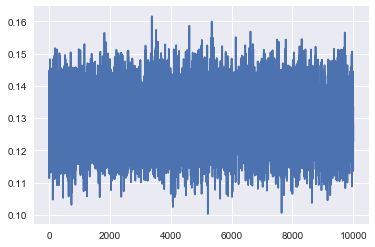

In [31]:
plt.plot(lss)

## A ratio-like and squared formula

Let $M=10$ and the function to learn is defined as 
$$
f(\mathbf x) = \frac{\sum_i a_i x_i + b} {\sum_i c_i x_i + d} + \alpha \sum_{i,j \neq i} x_i x_j + \beta
$$
where coefficients $a_i$, $b$, $c_i$, $d$, $\alpha$, $\beta$ are randomly chosen.

Setup input data :

In [107]:
import os
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

n_samples = 10000
n_features = 10
a = np.random.rand(n_features)
b = 1.0
c = np.random.rand(n_features)
d = np.random.rand() * 100.0
alpha = np.random.rand() * 1.0 / 50.0
beta = np.random.rand() * 50.0

x_max = 100.0
x_min = -100.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min
test_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [108]:
def f(sample_x):
    numerator = np.dot(a, sample_x) + b
    denominator = np.dot(c, sample_x) + d
    t1 = numerator / denominator
    
    t2 = 0
    for v in sample_x:
        t2 += v * (np.sum(sample_x) - v)    
    t2 *= alpha
    return t1 + t2 + beta

In [109]:
trainval_y = np.zeros((n_samples, 1))
test_y = np.zeros((n_samples, 1))

for i, x in enumerate(trainval_x):
    trainval_y[i] = f(x)
    
for i, x in enumerate(test_x):
    test_y[i] = f(x)    

In [110]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [111]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,18.908035,-65.778817,-76.054391,-66.212981,25.293067,19.119351,96.409735,57.607497,69.593030,-55.191581,-280.165355
1,-28.461742,62.323780,72.126596,85.355943,52.468099,-62.622827,24.144203,0.812550,-8.390462,31.654618,226.375988
2,-35.821878,44.524547,24.867569,36.366375,43.815772,-27.064073,67.136307,56.898283,9.977495,77.475432,548.374236
3,36.697332,-74.866707,-57.317503,90.349568,17.427056,80.388137,39.394559,-72.655997,-88.765190,45.267448,-327.751197
4,38.520690,-57.429805,81.155612,-42.665324,33.379119,-12.809968,49.171190,-53.091985,91.739268,-92.615075,-279.064649


In [558]:
y_min = df['y'].min()
y_max = df['y'].max()

y_mean = df['y'].mean()
y_std = df['y'].std()

def to_compact(y):
    return (y - y_min) / (y_max - y_min)    

def from_compact(y):
    return (y_max - y_min) * y + y_min

def normalize(y):
    return ( y - y_mean ) / (1e-10 + y_std)

def unnormalize(y):
    return  y_std * y + y_mean


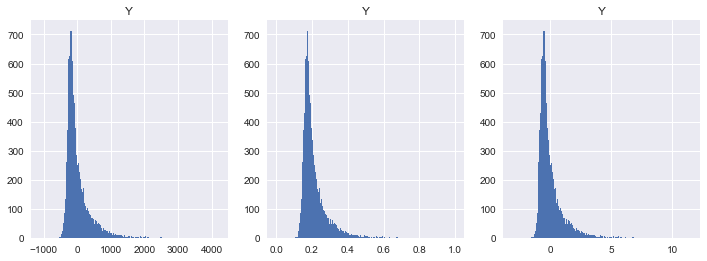

In [559]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
df['y'].hist(bins=200)
plt.title('Y')
plt.subplot(132)
df['y'].apply(to_compact).hist(bins=200)
plt.title('Y')
plt.subplot(133)
df['y'].apply(normalize).hist(bins=200)
plt.title('Y')


# plt.figure(figsize=(12, 6))
# for i in range(n_features):
#     plt.subplot(2, n_features/2, i+1)
#     df['x_%i' % i].hist(bins=100)
#     plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = \prod_{i=0}^{k-1} \left( b_i + \langle W_i, g(\mathbf x) \rangle \right),
$$
where 
$$
g(\mathbf x) = g_m(\mathbf x) = h^{(1)}_{m,m-1}(\mathbf x) +  h^{(2)}_{m,m-1}\left(\frac{1}{\epsilon +\mathbf x}\right)
$$
and 
$$
h^{(i)}_{m,m-1}(\mathbf x) = \text{activation}(\langle W_{i,m}, g_{m-1}(\mathbf x) \rangle + b_{i,m}), \\
g_{0} (\mathbf x) = \mathbf x
$$


In [86]:
import tensorflow as tf
from tf_bike.train import Trainer
tf.reset_default_graph()

In [606]:
def tf_rmse(Y_true, Y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)))


def tf_unnorm_rmse(Y_true, Y_pred):
    _Y_mean = tf.constant(y_mean, dtype=tf.float32)
    _Y_std = tf.constant(y_std, dtype=tf.float32)
    def _unnorm(Y):
        return _Y_std * Y + _Y_mean
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(_unnorm(Y_true) - _unnorm(Y_pred)), axis=-1)))


def tf_loss(Y_true, Y_pred):
    l1 = tf.reduce_mean(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))
    l2 = tf.log(1.0 + tf_rmse(Y_true, Y_pred))    
    return tf.minimum(l1, l2)

In [607]:
def h(index, m, x, n_filters, with_activation=True, seed=None):    
    
    b = tf.Variable(tf.random_uniform([n_filters], seed=seed), 
                    name='bias_%i_%i' % (index, m), dtype=tf.float32)
    W = tf.Variable(tf.random_uniform(shape=[x.get_shape().as_list()[1], n_filters], seed=seed), 
                    name="W_%i_%i" % (index, m), dtype=tf.float32)

    name = 'h_%i_%i' % (index, m)
    out = tf.add(tf.matmul(x, W), b)
    if with_activation:
        return tf.nn.elu(out, name=name)
    else:
        return tf.identity(out, name=name)
    
    
def g(m, x, n_filters_list, suffix='', **params):     
    assert len(n_filters_list) == m + 1, "n_filters_list should be of length m+1"
    epsilon = tf.constant(1e-10, name='eps')   
    _x = x if m == 0 else g(m-1, x, n_filters_list[:-1], suffix=suffix, **params)
    h1 = h(1, m, _x, n_filters_list[m], **params)
    h2 = h(2, m, tf.divide(tf.constant(1.0, dtype=tf.float32), tf.add(epsilon, _x)), n_filters_list[m], **params)
    return tf.add(h1, h2, name='g_%i%s' % (m, suffix))


def generic_nn(x, k, m, n_filters_lists, **params):  
    assert k > 0, "Parameter k should be positive"
    assert m > 0, "Parameter m should be positive"
    n_filters_list = n_filters_lists[0]   
    subnets = [h(3, 0, g(m-1, x, n_filters_list, **params), n_filters=1, with_activation=False, **params), ]
    for i in range(1, k):
        n_filters_list = n_filters_lists[i]        
        subnets.append(tf.multiply(subnets[-1], 
                                   h(3, i, g(m-1, x, n_filters_list, suffix="_%i" % i, **params), 
                                     n_filters=1, with_activation=False, **params)))
    net = tf.identity(subnets[-1], name="net_%i_%i" % (k, m))
    return net

In [533]:
from tf_bike.visu import show_graph

tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=(None, n_features), name="X")
n_filters_lists = [
    [5, 6, 7, 8],
    [9, 12, 11, 13],
]
network = generic_nn(X, 2, 4, n_filters_lists)

show_graph(network.graph)

In [608]:
training_params = {        
   
    # Loss
    'loss': tf_loss,
    
    # Optimizer
    'optimizer': tf.train.GradientDescentOptimizer,
    # 'optimizer': tf.train.AdadeltaOptimizer,
    
    # Metrics
    'metrics': [
        ('rmse', tf_rmse),
        ('unnorm_rmse', tf_unnorm_rmse),
    ],
    
    # Learning rate params
    'lr': lambda x, **kwargs: tf.train.exponential_decay(global_step=x, **kwargs),
    'lr_kwargs': {
        'decay_steps': 200,
        'decay_rate': 0.93,
        'learning_rate': 0.008,
        'staircase': True
    },

#     'lr': tf.train.piecewise_constant, 
#     'lr_kwargs': {
#         'boundaries': [50, 100, 200, 500, 1000, ],
#         'values': [1e-4, 5*1e-5, 5*1e-5, 1e-6, 1e-7]
#     },
    
    # Pretrained model
    # 'pretrained_model': 'best_from_logs',

    'training_epochs': 5000,
    'batch_size': 1024,
    
    'seed': 2017,
    
}

def nn(x):
    k = 3
    m = 3
    n_filters_lists = [
        [5, 5, 5],
        [5, 5, 5],        
        [5, 5, 5],        
    ]
    
    return generic_nn(x, k=k, m=m, n_filters_lists=n_filters_lists, seed=training_params['seed'])

# Network
training_params['network'] = nn



In [609]:
from datetime import datetime
trainer = Trainer(log_dir='logs_{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M")), display_step=50)

In [610]:
trainer.train(trainval_x, normalize(trainval_y), 
              training_params=training_params, 
              verbose=1)

Start training
Model contains 42 trainable variables and 708 trainable parameters
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path logs_2017-07-03-14-43\train\Model/net_3_3.ckpt
INFO:tensorflow:Starting queue runners.
Epoch: 0050
loss=0.508801870 | rmse=0.663297519 unnorm_rmse=241.007263184 
val_loss=0.500353634 | val_rmse=0.649304330 val_unnorm_rmse=235.922851562 
Epoch: 0100
loss=0.501982912 | rmse=0.651993833 unnorm_rmse=236.900058746 
val_loss=0.495775014 | val_rmse=0.641770124 val_unnorm_rmse=233.185379028 
Epoch: 0150
loss=0.504848905 | rmse=0.656735308 unnorm_rmse=238.622869492 
val_loss=0.495155215 | val_rmse=0.640752912 val_unnorm_rmse=232.815704346 
Epoch: 0200
loss=0.504878491 | rmse=0.656784266 unnorm_rmse=238.640659332 
val_loss=0.495198011 | val_rmse=0.640823126 val_unnorm_rmse=232.841217041 
Epoch: 0250
loss=0.504563719 | rmse=0.656262830 unnorm_rmse=238.451194763 
val_loss=0.495118111 | val_rmse=0.640691936 val_unnorm_rmse=232.793594

In [611]:
training_params['pretrained_model'] = 'best_from_logs'

In [612]:
y_preds = trainer.predict(test_x, training_params=training_params, verbose=1)

Start predictions
INFO:tensorflow:Restoring parameters from logs_2017-07-03-14-43\Model\net_3_3_seed=2017_loss=0.500968_val_loss=0.489811-448
-- 0 / 10  | 0 - 1024
-- 1 / 10  | 1024 - 2048
-- 2 / 10  | 2048 - 3072
-- 3 / 10  | 3072 - 4096
-- 4 / 10  | 4096 - 5120
-- 5 / 10  | 5120 - 6144
-- 6 / 10  | 6144 - 7168
-- 7 / 10  | 7168 - 8192
-- 8 / 10  | 8192 - 9216
-- 9 / 10  | 9216 - 10000


In [613]:
lss = np_loss_array(test_y[:100], unnormalize(y_preds[:100]))

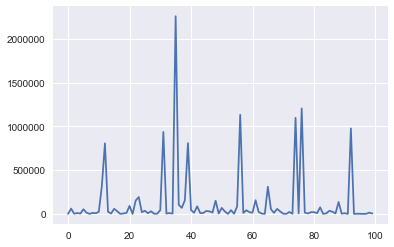

In [614]:
plt.plot(lss)

In [616]:
test_y[20:40], unnormalize(y_preds[20:40])

(array([[ -379.0533374 ],
        [  -29.21360344],
        [  312.62066205],
        [ -514.67466518],
        [  -81.02898682],
        [ -287.59183965],
        [ -147.92033276],
        [  114.67190417],
        [ -157.52177773],
        [ -116.10238259],
        [ -264.32864315],
        [  835.08562624],
        [  -42.84536694],
        [ -153.20306516],
        [ -110.74508219],
        [ 1395.79694268],
        [  266.76642322],
        [ -313.18427651],
        [  319.56361268],
        [  802.85826467]]), array([[ -76.74704952],
        [ -39.93901226],
        [ -78.04601441],
        [ -75.54284559],
        [  60.68743666],
        [ -98.31335145],
        [ -56.7160789 ],
        [ -59.18485613],
        [-109.95144107],
        [ -65.85758348],
        [ -56.61791775],
        [-132.27250639],
        [-110.45788329],
        [ -56.12906657],
        [ -51.5684715 ],
        [-106.82076642],
        [ -56.53983822],
        [ -49.78472156],
        [ -75.59466038],
    

Some manual check

In [509]:
def np_h(index, m, x, n_filters, b=None, w=None, with_activation=True):        

    assert b is not None and w is not None, "WTF | index=%i, m=%i " % (index, m)   
    print("-- index={}, m={}, x.shape={}, n_filters={}, b.shape={}, w.shape={}"
          .format(index, m, x.shape, n_filters, b.shape, w.shape))
    
    res = np.matmul(x, w) + b
    if with_activation:
        res[res < 0.0] = 0.0 
    return res

def np_g(m, x, n_filters_list, suffix='',  **params):
    print('- g({}) : n_filters_list={}'.format(m, n_filters_list))
    assert len(n_filters_list) == m + 1, "n_filters_list should be of length m+1"
    epsilon = 1e-10
    _x = x if m == 0 else np_g(m-1, x, n_filters_list[:-1], suffix=suffix, **params)
    
    print("m={}, suffix={}, _x.shape={}".format(m, suffix, _x.shape))
    # h1
    h1 = np_h(1, m, _x, n_filters_list[m], 
              b=params.get('bias_1_%i%s' % (m, suffix)), w=params.get('W_1_%i%s' % (m, suffix)))
    print("--> h1.shape={}".format(h1.shape))
    # h2 
    h2 = np_h(2, m, 1.0/(1e-10 + _x), n_filters_list[m], 
              b=params.get('bias_2_%i%s' % (m, suffix)), w=params.get('W_2_%i%s' % (m, suffix)))
    print("-- h2.shape={}".format(h2.shape))
    return h1 + h2   


def np_generic_nn(x, k, m, n_filters_lists, **params):    
    assert k > 0, "Parameter k should be positive"
    assert m > 0, "Parameter m should be positive"
    n_filters_list = n_filters_lists[0]
    print('\n--- h(3, 0) : n_filters_list={}'.format(n_filters_list))
    subnets = [np_h(3, 0, 
                    np_g(m-1, x, n_filters_list, **params), 
                    n_filters=1, 
                    with_activation=False, 
                    b=params.get('bias_3_0'), w=params.get('W_3_0')), ]
    for i in range(1, k):
        n_filters_list = n_filters_lists[i]        
        print('\n--- h(3, {}) : n_filters_list={}'.format(i, n_filters_list))
        ret = subnets[-1] *  np_h(3, i, 
                                  np_g(m-1, x, n_filters_list, suffix="_%i" % i, **params),
                                  n_filters=1, with_activation=False, 
                                  b=params.get('bias_3_%i' % i), w=params.get('W_3_%i' % i))
        subnets.append(ret)
    net = subnets[-1]
    return net

In [510]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))
n_filters = 15

In [511]:
h_1 = h(1, 0, X, n_filters, with_activation=False, seed=0)
B = tf.Variable(tf.random_uniform([n_filters], seed=seed))
W = tf.Variable(tf.random_uniform(shape=[X.get_shape().as_list()[1], n_filters], seed=seed))                

with tf.Session() as sess:
    x = 0.5*np.ones((5, n_features), dtype=np.float32)
    sess.run(tf.global_variables_initializer())
    b, w, h_res = sess.run([B, W, h_1], feed_dict={X: x})    
    h_res2 = np_h(1, 0, x, n_filters=n_filters, with_activation=True, b=b, w=w)
    print(np.mean(np.abs(h_res2 - h_res)))

-- index=1, m=0, x.shape=(5, 10), n_filters=15, b.shape=(15,), w.shape=(10, 15)
3.8147e-08


In [512]:
h_3 = h(3, 0, X, n_filters=1, with_activation=False, seed=0)

with tf.Session() as sess:
    x = 0.5*np.ones((5, n_features), dtype=np.float32)
    sess.run(tf.global_variables_initializer())
    
    vv = tf.global_variables()
    vv.append(h_3)
    ret = sess.run(vv, feed_dict={X: x})    
    
    h_res1 = ret[-1]
    
    params = {}
    for v, vv in zip(tf.global_variables(), ret[:-1]):
        name = v.name.replace(":0", "")
        params[name] = vv

    h_res2 = np_h(3, 0, x, n_filters=1, with_activation=False, b=params.get('bias_3_0'), w=params.get('W_3_0'))
    print(h_res1, h_res2)
    print(np.mean(np.abs(h_res1 - h_res2)))

-- index=3, m=0, x.shape=(5, 10), n_filters=1, b.shape=(1,), w.shape=(10, 1)
[[ 2.71125078]
 [ 2.71125078]
 [ 2.71125078]
 [ 2.71125078]
 [ 2.71125078]] [[ 2.71125078]
 [ 2.71125078]
 [ 2.71125078]
 [ 2.71125078]
 [ 2.71125078]]
0.0


In [513]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))
g_0 = g(0, X, [12, ], seed=0)

with tf.Session() as sess:
    x = 0.5*np.ones((5, n_features), dtype=np.float32)
    sess.run(tf.global_variables_initializer())
    
    vv = tf.global_variables()
    vv.append(g_0)
    ret = sess.run(vv, feed_dict={X: x})    
    
    g_0_res1 = ret[-1]
    
    params = {}
    for v, vv in zip(tf.global_variables(), ret[:-1]):
        name = v.name.replace(":0", "")
        params[name] = vv

    g_0_res2 = np_g(0, x, [12, ], **params)
    print(np.mean(np.abs(g_0_res1 - g_0_res2)))

- g(0) : n_filters_list=[12]
m=0, suffix=, _x.shape=(5, 10)
-- index=1, m=0, x.shape=(5, 10), n_filters=12, b.shape=(12,), w.shape=(10, 12)
--> h1.shape=(5, 12)
-- index=2, m=0, x.shape=(5, 10), n_filters=12, b.shape=(12,), w.shape=(10, 12)
-- h2.shape=(5, 12)
0.0


In [530]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))
g_1 = g(1, X, [12, 12, ], seed=0)

with tf.Session() as sess:
    x = 0.5*np.ones((5, n_features), dtype=np.float32)
    sess.run(tf.global_variables_initializer())
    
    vv = tf.global_variables()
    vv.append(g_1)
    ret = sess.run(vv, feed_dict={X: x})    
    
    g_res1 = ret[-1]
    
    params = {}
    for v, vv in zip(tf.global_variables(), ret[:-1]):
        name = v.name.replace(":0", "")
        params[name] = vv.astype(np.float32)

    g_res2 = np_g(1, x, [12, 12], **params)
    print(np.mean(np.abs(g_res1 - g_res2)))

- g(1) : n_filters_list=[12, 12]
- g(0) : n_filters_list=[12]
m=0, suffix=, _x.shape=(5, 10)
-- index=1, m=0, x.shape=(5, 10), n_filters=12, b.shape=(12,), w.shape=(10, 12)
--> h1.shape=(5, 12)
-- index=2, m=0, x.shape=(5, 10), n_filters=12, b.shape=(12,), w.shape=(10, 12)
-- h2.shape=(5, 12)
m=1, suffix=, _x.shape=(5, 12)
-- index=1, m=1, x.shape=(5, 12), n_filters=12, b.shape=(12,), w.shape=(12, 12)
--> h1.shape=(5, 12)
-- index=2, m=1, x.shape=(5, 12), n_filters=12, b.shape=(12,), w.shape=(12, 12)
-- h2.shape=(5, 12)
3.17891e-06


In [529]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))
g_2 = g(2, X, [12, 10, 8], seed=0)

with tf.Session() as sess:
    x = 0.5*np.ones((5, n_features), dtype=np.float32)
    sess.run(tf.global_variables_initializer())
    
    vv = tf.global_variables()
    vv.append(g_2)
    ret = sess.run(vv, feed_dict={X: x})    
    
    g_res1 = ret[-1]
    
    params = {}
    for v, vv in zip(tf.global_variables(), ret[:-1]):
        name = v.name.replace(":0", "")
        params[name] = vv

    g_res2 = np_g(2, x, [12, 10, 8], **params)
    print(np.mean(np.abs(g_res1 - g_res2)))

- g(2) : n_filters_list=[12, 10, 8]
- g(1) : n_filters_list=[12, 10]
- g(0) : n_filters_list=[12]
m=0, suffix=, _x.shape=(5, 10)
-- index=1, m=0, x.shape=(5, 10), n_filters=12, b.shape=(12,), w.shape=(10, 12)
--> h1.shape=(5, 12)
-- index=2, m=0, x.shape=(5, 10), n_filters=12, b.shape=(12,), w.shape=(10, 12)
-- h2.shape=(5, 12)
m=1, suffix=, _x.shape=(5, 12)
-- index=1, m=1, x.shape=(5, 12), n_filters=10, b.shape=(10,), w.shape=(12, 10)
--> h1.shape=(5, 10)
-- index=2, m=1, x.shape=(5, 12), n_filters=10, b.shape=(10,), w.shape=(12, 10)
-- h2.shape=(5, 10)
m=2, suffix=, _x.shape=(5, 10)
-- index=1, m=2, x.shape=(5, 10), n_filters=8, b.shape=(8,), w.shape=(10, 8)
--> h1.shape=(5, 8)
-- index=2, m=2, x.shape=(5, 10), n_filters=8, b.shape=(8,), w.shape=(10, 8)
-- h2.shape=(5, 8)
1.44958e-05


In [528]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))

n_filters_lists = [
    [5, 6, 7],
]
nn_1_3 = generic_nn(X, 1, 3, n_filters_lists)

with tf.Session() as sess:
    x = 0.5*np.ones((5, n_features), dtype=np.float32)
    sess.run(tf.global_variables_initializer())
    
    vv = tf.global_variables()
    vv.append(nn_1_3)
    ret = sess.run(vv, feed_dict={X: x})    
    
    nn_res1 = ret[-1]
    
    params = {}
    for v, vv in zip(tf.global_variables(), ret[:-1]):
        name = v.name.replace(":0", "")
        params[name] = vv

    nn_res2 = np_generic_nn(x, 1, 3, n_filters_lists, **params)
    print(np.mean(np.abs(nn_res1 - nn_res2)))
    print(nn_res1, nn_res2)
    


--- h(3, 0) : n_filters_list=[5, 6, 7]
- g(2) : n_filters_list=[5, 6, 7]
- g(1) : n_filters_list=[5, 6]
- g(0) : n_filters_list=[5]
m=0, suffix=, _x.shape=(5, 10)
-- index=1, m=0, x.shape=(5, 10), n_filters=5, b.shape=(5,), w.shape=(10, 5)
--> h1.shape=(5, 5)
-- index=2, m=0, x.shape=(5, 10), n_filters=5, b.shape=(5,), w.shape=(10, 5)
-- h2.shape=(5, 5)
m=1, suffix=, _x.shape=(5, 5)
-- index=1, m=1, x.shape=(5, 5), n_filters=6, b.shape=(6,), w.shape=(5, 6)
--> h1.shape=(5, 6)
-- index=2, m=1, x.shape=(5, 5), n_filters=6, b.shape=(6,), w.shape=(5, 6)
-- h2.shape=(5, 6)
m=2, suffix=, _x.shape=(5, 6)
-- index=1, m=2, x.shape=(5, 6), n_filters=7, b.shape=(7,), w.shape=(6, 7)
--> h1.shape=(5, 7)
-- index=2, m=2, x.shape=(5, 6), n_filters=7, b.shape=(7,), w.shape=(6, 7)
-- h2.shape=(5, 7)
-- index=3, m=0, x.shape=(5, 7), n_filters=1, b.shape=(1,), w.shape=(7, 1)
0.0
[[ 265.56387329]
 [ 265.56387329]
 [ 265.56387329]
 [ 265.56387329]
 [ 265.56387329]] [[ 265.56387329]
 [ 265.56387329]
 [ 265

In [527]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))

n_filters_lists = [
    [5, 10, 7, 8],
    [12, 16, 7, 3],
]
nn_2_4 = generic_nn(X, 2, 4, n_filters_lists, seed=0)

with tf.Session() as sess:
    x = 0.5*np.ones((5, n_features), dtype=np.float32)
    sess.run(tf.global_variables_initializer())
    
    vv = tf.global_variables()
    vv.append(nn_2_4)
    ret = sess.run(vv, feed_dict={X: x})    
    
    nn_res1 = ret[-1]
    
    params = {}
    for v, vv in zip(tf.global_variables(), ret[:-1]):
        name = v.name.replace(":0", "")
        params[name] = vv.astype(np.float32)

    nn_res2 = np_generic_nn(x, 2, 4, n_filters_lists, **params)
    print(np.mean(np.abs(nn_res1 - nn_res2)))
    print(nn_res1, nn_res2)


--- h(3, 0) : n_filters_list=[5, 10, 7, 8]
- g(3) : n_filters_list=[5, 10, 7, 8]
- g(2) : n_filters_list=[5, 10, 7]
- g(1) : n_filters_list=[5, 10]
- g(0) : n_filters_list=[5]
m=0, suffix=, _x.shape=(5, 10)
-- index=1, m=0, x.shape=(5, 10), n_filters=5, b.shape=(5,), w.shape=(10, 5)
--> h1.shape=(5, 5)
-- index=2, m=0, x.shape=(5, 10), n_filters=5, b.shape=(5,), w.shape=(10, 5)
-- h2.shape=(5, 5)
m=1, suffix=, _x.shape=(5, 5)
-- index=1, m=1, x.shape=(5, 5), n_filters=10, b.shape=(10,), w.shape=(5, 10)
--> h1.shape=(5, 10)
-- index=2, m=1, x.shape=(5, 5), n_filters=10, b.shape=(10,), w.shape=(5, 10)
-- h2.shape=(5, 10)
m=2, suffix=, _x.shape=(5, 10)
-- index=1, m=2, x.shape=(5, 10), n_filters=7, b.shape=(7,), w.shape=(10, 7)
--> h1.shape=(5, 7)
-- index=2, m=2, x.shape=(5, 10), n_filters=7, b.shape=(7,), w.shape=(10, 7)
-- h2.shape=(5, 7)
m=3, suffix=, _x.shape=(5, 7)
-- index=1, m=3, x.shape=(5, 7), n_filters=8, b.shape=(8,), w.shape=(7, 8)
--> h1.shape=(5, 8)
-- index=2, m=3, x.shap